In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

sns.set(font_scale=1.1, style='white', rc={'lines.linewidth': 2})

df_wo_inf = pd.read_csv("csvs_final/all_data_final_no_inf.csv")
df_with_inf =  pd.read_csv("csvs_final/all_data_final_with_inf.csv")

baseline_fillup = pd.read_csv("csvs_final/baseline_fillup.csv")

## df for baseline
df_bsline_with_inf = df_with_inf[df_with_inf.hierarchy=='[1]']
df_bsline_wo_inf = df_wo_inf[df_wo_inf.hierarchy=='[1]']


In [2]:
# to fix errors with saving the pdf https://stackoverflow.com/a/60384073/2745116
from matplotlib import rc
plt.rcParams['pdf.fonttype'] = 42

In [3]:
# map original labels to something else
label_mapping = {
    '[1]': r'$\hat{k}=1$',
    '[2]': r'$\hat{k}=2$',
    '[2, 4]': r'$\hat{k}=3$',
}

def mapped_labels(original_labels):
    return [label_mapping[l] for l in original_labels]

In [4]:
def get_df(k):
    """Get and return df for k1, k2, k3"""
    assert k in {'k1', 'k2', 'k3'}
    if k == 'k1':
        return df_wo_inf[df_wo_inf['hierarchy'] == '[1]']
    if k == 'k2':
        return df_wo_inf[df_wo_inf['hierarchy'] == '[2]']
    if k == 'k3':
        return df_wo_inf[df_wo_inf['hierarchy'] == '[2, 4]']
    return None

# analyze difference between k=1,2,3
def analyze_ratio(metric, numerator='k3', denominator='k1'):
    df_num = get_df(numerator)
    df_denom = get_df(denominator)

#     np.mean(df_k3[metric].to_numpy() / df_k1[metric].to_numpy())

    # how much do the means per request deviate?
    ratios = []
    for r in range(1, 6):
        mean_num = df_num[df_num['request_count'] == r][metric].mean()
        mean_denom = df_denom[df_denom['request_count'] == r][metric].mean()
        ratio = mean_num / mean_denom
        print(f'Ratio {numerator}/{denominator} for {r} requests: {ratio}')
        ratios.append(ratio)
        
    print(f'Min: {min(ratios)}, Max: {max(ratios)}, Mean: {np.mean(ratios)}')

['[1]' '[2]' '[2, 4]']


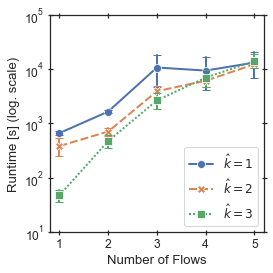

In [5]:
## runtime plots

# old
# sns_plot = sns.relplot(data=df_wo_inf, x="request_count", markers=True, y="runtime", style="hierarchy", kind="line", legend=False)
# sns_plot.set(xlabel='Amount of VNF requests', ylabel='Runtime in ms [log]')
# ax = sns_plot.axes[0][0]
# ax.set_yscale("log")
# plt.legend(title='Approach', loc='lower right', labels=['Baseline', '[1,2]', '[1,2,4]'])
# sns_plot.savefig("final_figs/final_runtimes.pdf")


def plot_runtime(df):
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.set(font_scale=1.1, style='white', rc={'lines.linewidth': 2})
    
    print(df['hierarchy'].unique())
    sns.lineplot(df['request_count'], df['runtime'] / 1000, hue=df['hierarchy'], style=df['hierarchy'], markers=True, markersize=8, legend=False,
                err_style='bars', err_kws={'capsize': 4})
    
    ax.set_xlabel('Number of Flows')
    ax.set_ylabel('Runtime [s] (log. scale)')
    ax.set_yscale('log')
    ax.set_ylim(10**1, 10**5)
    ax.tick_params(axis='both', direction='inout', length=5, bottom=True, left=True, right=True, top=True)
    plt.legend(labels=mapped_labels(df['hierarchy'].unique()))
    
    plt.tight_layout()
    fig.savefig('final_figs/runtime.pdf')
    
plot_runtime(df_wo_inf)

In [6]:
analyze_ratio('runtime', numerator='k1', denominator='k3')

Ratio k1/k3 for 1 requests: 14.039137608004829
Ratio k1/k3 for 2 requests: 3.490641264692949
Ratio k1/k3 for 3 requests: 4.047355549885894
Ratio k1/k3 for 4 requests: 1.3483874411788275
Ratio k1/k3 for 5 requests: 0.9387512659005236
Min: 0.9387512659005236, Max: 14.039137608004829, Mean: 4.772854625932604


In [7]:
analyze_ratio('runtime', numerator='k1', denominator='k2')

Ratio k1/k2 for 1 requests: 1.7344473383386025
Ratio k1/k2 for 2 requests: 2.3320870761453967
Ratio k1/k2 for 3 requests: 2.7372526390226364
Ratio k1/k2 for 4 requests: 1.5387561753523533
Ratio k1/k2 for 5 requests: 1.0735855503144611
Min: 1.0735855503144611, Max: 2.7372526390226364, Mean: 1.8832257558346903


['[1]' '[2]' '[2, 4]']


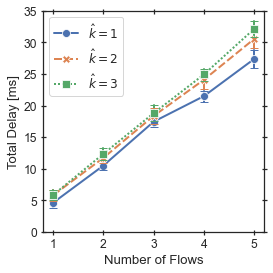

In [8]:
# sum tot delay makes only sense for the w/o inf df
# sns_plot = sns.relplot(data=df_wo_inf, x="request_count", markers=True, ci="sd", y="sum_total_delay", style="hierarchy", kind="line", legend=False)
# sns_plot.set(xlabel='Amount of VNF requests', ylabel='Avg. sum of the total delay of all requests [ms]')
# plt.legend(title='Approach', loc='upper left', labels=['Baseline', '[1,2]', '[1,2,4]'])
# sns_plot.savefig("final_figs/final_accumulated_tot_delay.pdf")

def plot_delay(df):
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.set(font_scale=1.1, style='white', rc={'lines.linewidth': 2})
    
    print(df['hierarchy'].unique())
    sns.lineplot(df['request_count'], df['sum_total_delay'], hue=df['hierarchy'], style=df['hierarchy'], markers=True, markersize=8, legend=False,
                err_style='bars', err_kws={'capsize': 4})
    
    ax.set_xlabel('Number of Flows')
    ax.set_ylabel('Total Delay [ms]')
    ax.set_ylim(0, 35)
    ax.tick_params(axis='both', direction='inout', length=5, bottom=True, left=True, right=True, top=True)
    plt.legend(labels=mapped_labels(df['hierarchy'].unique()))
    
    plt.tight_layout()
    fig.savefig('final_figs/total_delay.pdf')
    
plot_delay(df_wo_inf)

In [9]:
analyze_ratio('sum_total_delay')

Ratio k3/k1 for 1 requests: 1.2680510324454204
Ratio k3/k1 for 2 requests: 1.176557213089767
Ratio k3/k1 for 3 requests: 1.07766541555919
Ratio k3/k1 for 4 requests: 1.1598862750934744
Ratio k3/k1 for 5 requests: 1.1741791440663432
Min: 1.07766541555919, Max: 1.2680510324454204, Mean: 1.1712678160508392


In [10]:
analyze_ratio('sum_total_delay', numerator='k2', denominator='k1')

Ratio k2/k1 for 1 requests: 1.2587331394534613
Ratio k2/k1 for 2 requests: 1.1163070991537853
Ratio k2/k1 for 3 requests: 1.0524612878592874
Ratio k2/k1 for 4 requests: 1.1209370946458195
Ratio k2/k1 for 5 requests: 1.115915171031469
Min: 1.0524612878592874, Max: 1.2587331394534613, Mean: 1.1328707584287645


['[1]' '[2]' '[2, 4]']


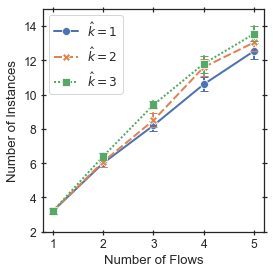

In [11]:
# placements makes only sense for the w/o inf df
# sns_plot = sns.relplot(data=df_wo_inf, x="request_count", markers=True, ci='sd', y="placements", style="hierarchy", kind="line", legend=False)
# sns_plot.set(xlabel='Amount of VNF requests', ylabel='Avg. amount of components placed')
# plt.legend(title='Approach', loc='upper left', labels=['Baseline', '[1,2]', '[1,2,4]'])
# sns_plot.savefig("final_figs/final_placements.pdf")

def plot_vnfs(df):
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.set(font_scale=1.1, style='white', rc={'lines.linewidth': 2})
    
    print(df['hierarchy'].unique())
    sns.lineplot(df['request_count'], df['placements'], hue=df['hierarchy'], style=df['hierarchy'], markers=True, markersize=8, legend=False,
                err_style='bars', err_kws={'capsize': 4})
    
    ax.set_xlabel('Number of Flows')
    ax.set_ylabel('Number of Instances')
    ax.set_ylim(2, 15)
    ax.tick_params(axis='both', direction='inout', length=5, bottom=True, left=True, right=True, top=True)
    plt.legend(labels=mapped_labels(df['hierarchy'].unique()))
    
    plt.tight_layout()
    fig.savefig('final_figs/num_vnfs.pdf')
    
plot_vnfs(df_wo_inf)

In [12]:
analyze_ratio('placements')

Ratio k3/k1 for 1 requests: 1.0
Ratio k3/k1 for 2 requests: 1.0666666666666667
Ratio k3/k1 for 3 requests: 1.1463414634146343
Ratio k3/k1 for 4 requests: 1.1132075471698115
Ratio k3/k1 for 5 requests: 1.079734219269103
Min: 1.0, Max: 1.1463414634146343, Mean: 1.0811899793040431


In [13]:
analyze_ratio('placements', numerator='k2', denominator='k1')

Ratio k2/k1 for 1 requests: 1.0
Ratio k2/k1 for 2 requests: 1.0133333333333334
Ratio k2/k1 for 3 requests: 1.0365853658536586
Ratio k2/k1 for 4 requests: 1.0943396226415094
Ratio k2/k1 for 5 requests: 1.039734219269103
Min: 1.0, Max: 1.0943396226415094, Mean: 1.0367985082195208


Need the following runs: set()


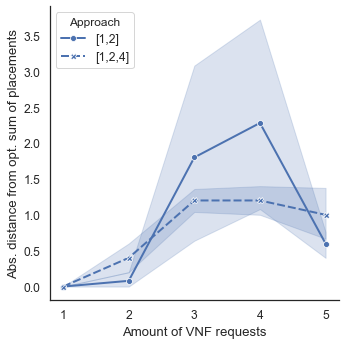

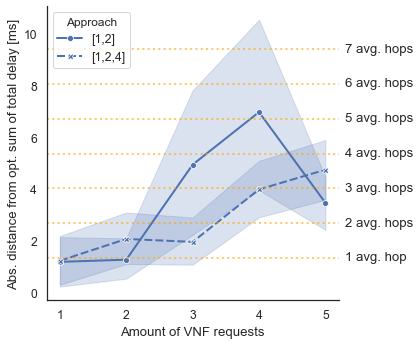

In [14]:
# WITH INFEASIBLES!

## Distances from optimal solution

# placements (cuz its easy)
distances = pd.DataFrame(columns=["hierarchy", "gurobi_seed", "vnf_requests_id","requests_count", "placements_distance", "total_delay_distance"])

needed_runs = set()

for (i, gurobi_seed, hierarchy_id, hierarchy, hierarchy_paths, graph_path, vnf_requests_id, ingr_egr, requests_count, vnf_requests_path, placements, runtime, avg_total_delay,avg_e2e_delay,sum_total_delay,sum_e2e_delay, method) in df_with_inf.itertuples():
  #  print("hierarchy: {}, gurobi_seed:{}, vnf_requests_id:{}, placements:{}, s_total_delay:{}".format(hierarchy, gurobi_seed, vnf_requests_id,placements, sum_total_delay))
    # now placement distance ->
    if hierarchy == '[1]':
        # no loss for baseline
        continue
    opt = df_bsline_with_inf[(df_bsline_with_inf.gurobi_seed == gurobi_seed) & (df_bsline_with_inf.vnf_requests_id == vnf_requests_id)]
    next_gurobi_seed = int(gurobi_seed)
    ctr = 0
    # if the run failed for the baseline check if there is another seed (they are all the same)
    while len(opt) == 0 and ctr < 5:
        next_gurobi_seed = int(next_gurobi_seed) + 1 % 5
        opt = df_bsline_with_inf[(df_bsline_with_inf.gurobi_seed == next_gurobi_seed) & (df_bsline_with_inf.vnf_requests_id == vnf_requests_id)]
        ctr += 1
    if len(opt) == 0:
        continue
    if placements == 'INFEASIBLE':
        distance = float(opt['placements'])
     #   continue
    else:
        distance = float(abs(float(placements)-float(opt['placements'])))
    if distance == 0:
        tot_delay_distance = abs(float(sum_total_delay) - float(opt['sum_total_delay']))
        distances = distances.append({'hierarchy': hierarchy, 'gurobi_seed':gurobi_seed, 'vnf_requests_id':vnf_requests_id, 'placements_distance':distance, 'total_delay_distance':float(tot_delay_distance), 'requests_count':requests_count}, ignore_index=True)
    else:
        if placements == 'INFEASIBLE':
            tot_delay_distance = float(opt['sum_total_delay'])
        else:
            bs_fillup = baseline_fillup.query("vnf_requests_id == {} & placements == {}".format(vnf_requests_id, placements))
            tot_delay_opt = bs_fillup['sum_total_delay']
            tot_delay_distance = abs(float(sum_total_delay) - float(tot_delay_opt))
            
        distances = distances.append({'hierarchy': hierarchy, 'gurobi_seed':gurobi_seed, 'vnf_requests_id':vnf_requests_id, 'placements_distance':distance, 'total_delay_distance':tot_delay_distance, 'requests_count':requests_count}, ignore_index=True)

       # print ("Seed:{}, vnf_requests_id:{} needs an opt run with placements set to {}".format(gurobi_seed, vnf_requests_id, placements))

sns_plot = sns.relplot(data=distances, x="requests_count", markers=True, y="placements_distance", style="hierarchy", kind="line", legend=False)
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Abs. distance from opt. sum of placements')
plt.legend(title='Approach', loc='upper left', labels=['[1,2]', '[1,2,4]'])

sns_plot.savefig("final_figs/final_absolute_placements_w_inf.pdf")



sns_plot = sns.relplot(data=distances, x="requests_count",markers=True, y="total_delay_distance", style="hierarchy", kind="line", legend=False)
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Abs. distance from opt. sum of total delay [ms]')
plt.legend(title='Approach', loc='upper left', labels=['[1,2]', '[1,2,4]'])
plt.xticks(np.arange(1,6,1))
ax1= sns_plot.axes[0][0]

avg_delay = 1.342150105084392
ax1.axhline(avg_delay, ls=':', color='orange', alpha=0.6)
ax1.text(5.3, avg_delay - .1, "1 avg. hop")
ax1.text(5.3, 2 * avg_delay - .1, "2 avg. hops")
ax1.text(5.3, 3* avg_delay - .1, "3 avg. hops")
ax1.text(5.3, 4*avg_delay -.1, "4 avg. hops")
ax1.text(5.3, 5*avg_delay-.1, "5 avg. hops")
ax1.text(5.3, 6*avg_delay-.1, "6 avg. hops")
ax1.text(5.3, 7*avg_delay-.1, "7 avg. hops")
ax1.axhline(2 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(3 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(4 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(5 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(6 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(7 * avg_delay, ls=':', color='orange', alpha=0.6)
sns_plot.savefig("final_figs/final_absolute_distance_tot_w_inf.pdf")



print("Need the following runs: {}".format(needed_runs))

    

Need the following runs: set()


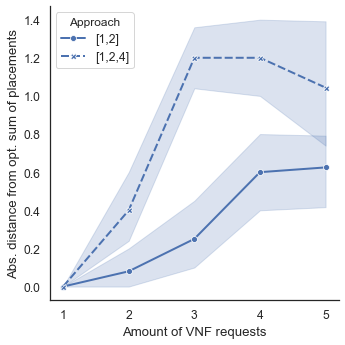

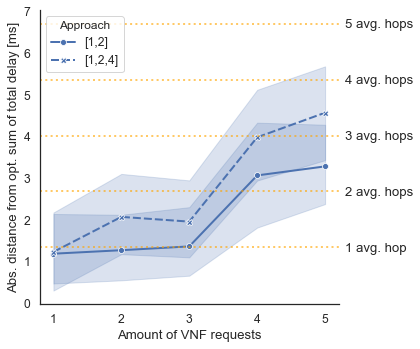

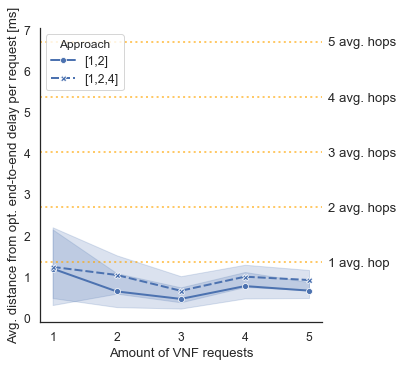

In [15]:
# WITHOUT INFEASIBLES!

## Distances from optimal solution

# placements (cuz its easy)
distances = pd.DataFrame(columns=["hierarchy", "gurobi_seed", "vnf_requests_id","requests_count", "placements_distance", "total_delay_distance", "e2e_delay_distance", "sum_e2e_delay_distance"])

needed_runs = set()

for (i, gurobi_seed, hierarchy_id, hierarchy, hierarchy_paths, graph_path, vnf_requests_id, ingr_egr, requests_count, vnf_requests_path, placements, runtime, avg_total_delay,avg_e2e_delay,sum_total_delay,sum_e2e_delay, method) in df_wo_inf.itertuples():
    # now placement distance ->
    if hierarchy == '[1]':
        # no loss for baseline
        continue
    
    opt = df_bsline_wo_inf[(df_bsline_wo_inf.gurobi_seed == gurobi_seed) & (df_bsline_wo_inf.vnf_requests_id == vnf_requests_id)]
    next_gurobi_seed = int(gurobi_seed)
    ctr = 0
    # if the run failed for the baseline check if there is another seed (they are all the same)
    while len(opt) == 0 and ctr < 5:
        next_gurobi_seed = int(next_gurobi_seed) + 1 % 5
        opt = df_bsline_wo_inf[(df_bsline_wo_inf.gurobi_seed == gurobi_seed) & (df_bsline_wo_inf.vnf_requests_id == vnf_requests_id)]
        ctr += 1
    if len(opt) == 0:
        continue
    if placements == 'INFEASIBLE':
        distance = float(opt['placements'])
    else:
        distance = float(abs(float(placements)-float(opt['placements'])))
    # delay distances
    if distance == 0:
        tot_delay_distance = abs(sum_total_delay - opt['sum_total_delay'])
        avg_e2e_delay_distance = abs(avg_e2e_delay - opt['avg_e2e_delay'] )
        sum_e2e_delay_distance = abs(sum_e2e_delay - opt['sum_e2e_delay'])
        
        distances = distances.append({'hierarchy': hierarchy, 'gurobi_seed':gurobi_seed, 'vnf_requests_id':vnf_requests_id, 'placements_distance':distance,
                                      'total_delay_distance':float(tot_delay_distance), 'requests_count':requests_count, 'e2e_delay_distance':float(avg_e2e_delay_distance),
                                     'sum_e2e_delay_distance': float(sum_e2e_delay_distance)}, ignore_index=True)
    else:
        if placements == 'INFEASIBLE':
            tot_delay_distance = float(opt['sum_total_delay'])
            avg_e2e_delay_distance=float(opt['avg_e2e_delay'])
        else:
            bs_fillup = baseline_fillup.query("vnf_requests_id == {} & placements == {}".format(vnf_requests_id, placements))
            tot_delay_opt = bs_fillup['sum_total_delay']
            tot_delay_distance = abs(float(sum_total_delay) - float(tot_delay_opt))
            avg_e2e_delay_opt = bs_fillup['avg_e2e_delay']
            avg_e2e_delay_distance = abs(float(avg_e2e_delay) - float(avg_e2e_delay_opt))
            sum_e2e_delay_opt = bs_fillup['sum_e2e_delay']
            sum_e2e_delay_distance = abs(float(sum_e2e_delay) - float(sum_e2e_delay_opt))
            
        distances = distances.append({'hierarchy': hierarchy, 'gurobi_seed':gurobi_seed, 'vnf_requests_id':vnf_requests_id, 'placements_distance':distance,
                                      'total_delay_distance':tot_delay_distance, 'requests_count':requests_count, 'e2e_delay_distance':float(avg_e2e_delay_distance),
                                     'sum_e2e_delay_distance': float(sum_e2e_delay_distance)}, ignore_index=True)

        
# plot the placements distances
sns_plot = sns.relplot(data=distances, x="requests_count", markers=True, y="placements_distance", style="hierarchy", kind="line", legend=False)
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Abs. distance from opt. sum of placements')
plt.legend(title='Approach', loc='upper left', labels=['[1,2]', '[1,2,4]'])
sns_plot.savefig("final_figs/final_absolute_placements_wo_inf.pdf")

# total delay distance
sns_plot = sns.relplot(data=distances, x="requests_count",markers=True, y="total_delay_distance", style="hierarchy", kind="line", legend=False)
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Abs. distance from opt. sum of total delay [ms]')
plt.legend(title='Approach', loc='upper left', labels=['[1,2]', '[1,2,4]'])

plt.xticks(np.arange(1,6,1))
ax1= sns_plot.axes[0][0]

avg_delay = 1.342150105084392
ax1.axhline(avg_delay, ls=':', color='orange', alpha=0.6)
ax1.text(5.3, avg_delay - .1, "1 avg. hop")
ax1.text(5.3, 2 * avg_delay - .1, "2 avg. hops")
ax1.text(5.3, 3* avg_delay - .1, "3 avg. hops")
ax1.text(5.3, 4*avg_delay -.1, "4 avg. hops")
ax1.text(5.3, 5*avg_delay-.1, "5 avg. hops")
ax1.axhline(2 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(3 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(4 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(5 * avg_delay, ls=':', color='orange', alpha=0.6)
sns_plot.savefig("final_figs/final_absolute_distance_tot_wo_inf.pdf")


# avg e2e delay distance
sns_plot = sns.relplot(data=distances, x="requests_count",markers=True, y="e2e_delay_distance", style="hierarchy", kind="line", legend=False)
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Avg. distance from opt. end-to-end delay per request [ms]')
plt.legend(title='Approach', loc='upper left', labels=['[1,2]', '[1,2,4]'])

plt.xticks(np.arange(1,6,1))
ax1= sns_plot.axes[0][0]

avg_delay = 1.342150105084392
ax1.axhline(avg_delay, ls=':', color='orange', alpha=0.6)
ax1.text(5.3, avg_delay - .1, "1 avg. hop")
ax1.text(5.3, 2 * avg_delay - .1, "2 avg. hops")
ax1.text(5.3, 3* avg_delay - .1, "3 avg. hops")
ax1.text(5.3, 4*avg_delay -.1, "4 avg. hops")
ax1.text(5.3, 5*avg_delay-.1, "5 avg. hops")
ax1.axhline(2 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(3 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(4 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(5 * avg_delay, ls=':', color='orange', alpha=0.6)
sns_plot.savefig("final_figs/final_e2e.pdf")

print("Need the following runs: {}".format(needed_runs))
